In [1]:
import rdkit

import pandas as pd
import numpy as np
from copy import deepcopy

from torch_geometric.datasets import MoleculeNet
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem

In [2]:
import custom_classification_functions
import custom_models
from custom_classification_functions import *
from custom_models import *
import custom_general_functions
from custom_general_functions import *

from copy import deepcopy

In [3]:
from torch_geometric.nn import global_mean_pool, global_max_pool

model_type = "GNN"

filename_basic = "results_classification_random_gnn/model_gnn_conv"

apply_scaffold_split = False

hidden_channels=[64]
gcn_layers=4
linear_sizes=[[512], [512, 256]]
aggregations=[global_mean_pool, global_max_pool]
apply_random_aggregations=False

learning_rate=0.001

In [4]:
param_combinations = dict()

hidden_channels_list = [[64], [256], [512]]
linear_sizes_list = [[], [512], [512, 256]]
gcn_layers_list = [1, 2, 3, 4]
aggregations_list = [[global_mean_pool, global_max_pool], [global_mean_pool], [global_max_pool]]
apply_scaffold_split_list = [False]

In [5]:
create_new_data = False

In [6]:
param_combinations["hidden_channels_list"] = hidden_channels_list
param_combinations["linear_sizes_list"] = linear_sizes_list

param_combinations["gcn_layers_list"] = gcn_layers_list
param_combinations["aggregations_list"] = aggregations_list
param_combinations["apply_scaffold_split_list"] = apply_scaffold_split_list

In [7]:
import itertools


keys = list(param_combinations.keys())
values = list(param_combinations.values())

combinations = list(itertools.product(*values))

In [8]:
batch_size = 64

In [9]:
use_fingerprints = False

if use_fingerprints:
    param_combinations_fp = dict()

    param_combinations_fp["radius"] = [2, 3]
    param_combinations_fp["fpSize"] = [1024, 2048]
    param_combinations_fp["linear_layers"] = [[2048], [2048, 1024, 512], [1024, 512], [1024]]
    param_combinations_fp["create_count_fp"] = [True, False]
    param_combinations_fp["apply_scaffold_split_list"] = apply_scaffold_split_list

    keys_fp = list(param_combinations_fp.keys())
    values_fp = list(param_combinations_fp.values())

    combinations_fp = list(itertools.product(*values_fp))


In [10]:
if use_fingerprints:

    combinations = combinations_fp
    keys = keys_fp
    values = values_fp

In [11]:
print(len(combinations))

108


run: 0
{'hidden_channels_list': [64], 'linear_sizes_list': [], 'gcn_layers_list': 1, 'aggregations_list': [<function global_mean_pool at 0x000001FE26709940>, <function global_max_pool at 0x000001FE2670E310>], 'apply_scaffold_split_list': False}
[<torch.utils.data.dataset.Subset object at 0x000001FE09ECB100>, <torch.utils.data.dataset.Subset object at 0x000001FE4BE25670>, <torch.utils.data.dataset.Subset object at 0x000001FE4BE25BB0>]
GCN_molecule_classification(
  (convs): ModuleList()
  (additional_layers): ModuleList()
  (out): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Number of parameters:  257


j:\Anaconda3\envs\newest_dgl\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0 | Train Loss 0.17373164129054663 | Validation Loss 0.14839198896589206 | Validation accuracy 0.9660068969448244
Epoch 10 | Train Loss 0.1533039827442285 | Validation Loss 0.1472855697191039 | Validation accuracy 0.966327519379845
Epoch 20 | Train Loss 0.15324769335464367 | Validation Loss 0.14728821958451307 | Validation accuracy 0.966327519379845
Epoch 30 | Train Loss 0.15444840720845657 | Validation Loss 0.14920741126172302 | Validation accuracy 0.9660068969448244
Epoch 40 | Train Loss 0.1533138555302782 | Validation Loss 0.1492381973206535 | Validation accuracy 0.9660068969448244
Epoch 50 | Train Loss 0.15437706936765644 | Validation Loss 0.1480133715410565 | Validation accuracy 0.9661137710898312
run: 1
{'hidden_channels_list': [64], 'linear_sizes_list': [], 'gcn_layers_list': 1, 'aggregations_list': [<function global_mean_pool at 0x000001FE26709940>], 'apply_scaffold_split_list': False}
[<torch.utils.data.dataset.Subset object at 0x000001FE2959CE80>, <torch.utils.data.data

KeyboardInterrupt: 

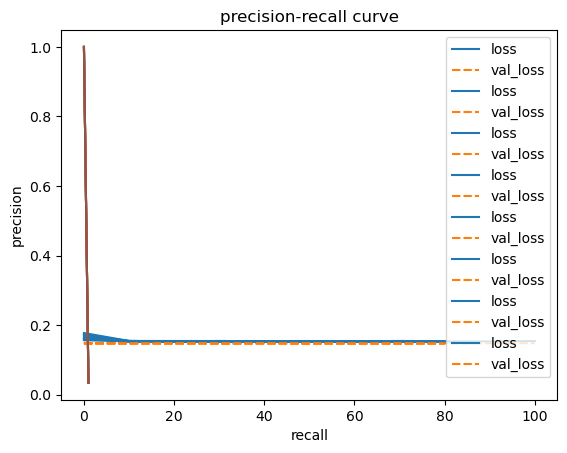

In [12]:

counter = 0
for combination in combinations:
    print(f"run: {counter}")
    counter = counter + 1
    
    #print(combination)
    combination_dict = dict(zip(keys, combination))
    print(combination_dict)
    #print(combination_dict["gcn_layers_list"])

    apply_scaffold_split = combination_dict["apply_scaffold_split_list"]

    if not use_fingerprints:
        hidden_channels=combination_dict["hidden_channels_list"]
        gcn_layers=combination_dict["gcn_layers_list"]
        linear_sizes=combination_dict["linear_sizes_list"]
        aggregations=deepcopy(combination_dict["aggregations_list"])
    else:
        radius = combination_dict["radius"] 
        fpSize = combination_dict["fpSize"]
        linear_layers = combination_dict["linear_layers"] 
        create_count_fp = combination_dict["create_count_fp"] 



    if create_new_data:
        data, data_y = load_hiv()

        pytorch_graph_list = create_pytorch_graph(data)

        processed_data = process_pytorch_graph(pytorch_graph_list, data_y)

        train_dataset, test_dataset, val_dataset = create_train_test_graphs(processed_data, train_percentage= 0.8, apply_scaffold_split = apply_scaffold_split )
        loader, test_loader = create_dataloader(train_dataset, test_dataset, batch_size=batch_size)

    else:

        import dill as pickle

        if apply_scaffold_split:
            loader_file = 'datasets_scaffold_class_hiv.pkl'
        else: 
            loader_file = 'datasets_class_hiv.pkl'
        with open(loader_file, 'rb') as file: 
            
            
            loaders = pickle.load(file) 
        
            print(loaders) 

        train_dataset, test_dataset, val_dataset = loaders


        if use_fingerprints:
            morgan_data_train, morgan_data_test, morgan_data_val = create_fingerprint_sets(datasets=[train_dataset, test_dataset, val_dataset], radius=radius, fpSize = fpSize, create_count_fp = create_count_fp)

            loader = DataLoader(morgan_data_train, 
                                batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(morgan_data_test, 
                                    batch_size=batch_size, shuffle=True)

        else:
            loader, test_loader = create_dataloader(train_dataset, test_dataset, batch_size=batch_size)
        

    if not use_fingerprints:
        model, device, optimizer, loss_fn = initialize_classification_model(input_dim=train_dataset.dataset[0].x.shape[-1], hidden_channels=hidden_channels, gcn_layers=gcn_layers, linear_sizes=linear_sizes, aggregations=aggregations, apply_random_aggregations=apply_random_aggregations, learning_rate=learning_rate)


        model, best_model_weights, losses, val_losses = classification_train(model, loader, test_loader, device, loss_fn, optimizer, log_time=10, max_epochs=1000, apply_early_stopping = True, early_stopping_patience = 50, finally_plot_losses = True)

        precisions, recalls, thresholds, dfs = predict_classification(model, test_loader, device)

    else:

        model, device, optimizer, loss_fn = initialize_regression_model_fingerprint( linear_layers=[1024, 512], learning_rate=learning_rate)


        model, best_model_weights, losses, val_losses = regression_train_fingerprint(model, loader, test_loader, device, loss_fn, optimizer, log_time=100, max_epochs=2000, apply_early_stopping = False, early_stopping_patience = 200, finally_plot_losses = True)

        mean_mse, mean_l1 = predict_regression_fingerprint(model, test_loader, device)



    final_df = pd.concat(dfs)
    
    save_dict = dict()

    save_dict["pred_df"] = final_df

    aggregations_names = [x.__name__ for x in aggregations]

    save_dict["apply_scaffold_split"] = apply_scaffold_split

    save_dict["hidden_channels"] = hidden_channels
    save_dict["gcn_layers"] = gcn_layers
    save_dict["linear_sizes"] = linear_sizes
    save_dict["aggregations"] = aggregations_names
    save_dict["apply_random_aggregations"] = apply_random_aggregations
    save_dict["learning_rate"] = learning_rate

    save_dict["model_type"] = model_type
    save_dict["model"] = model

    from os.path import exists
    final_filename = filename_basic
    counter = 1
    while exists(final_filename):
        final_filename = filename_basic + "_" + str(counter)
        counter = counter + 1

    import pickle
    with open(final_filename, 'wb') as handle:
        pickle.dump(save_dict, handle)


    